<a href="https://colab.research.google.com/github/aenoboa1/Draft_ML_EmotionAPP/blob/main/testing_daisee_XCeption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  Engagement Recognition  | Train Code - XCeption Test

#### Transformando dataset a TFRecords para el training

In [ ]:
!git clone https://github.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset

Cloning into 'Engagement-recognition-using-DAISEE-dataset'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 79 (delta 33), reused 47 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
import tensorflow_datasets as tfds
import pandas as pd
import random


AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
np.random.seed(0)

In [ ]:
class DataPreprocessing:
    def __init__(self,
                 IMG_HEIGHT=224,
                 IMG_WIDTH=224,
                 dataset_dir='/content/DAiSEE/DAiSEE/DataSet/Data/',
                 test_dir='Test/',
                 train_dir='Train/',
                 val_dir='Validation/',
                 labels_dir='/content/DAiSEE/DAiSEE/Labels/',
                 test_label='TestLabels.csv',
                 train_label='TrainLabels.csv',
                 val_label='ValidationLabels.csv',
                 data_augmentation_flag=False,
                 max_frames=3
                 ):
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.dataset_dir = dataset_dir
        self.train_dir = self.dataset_dir+train_dir
        self.test_dir = self.dataset_dir+test_dir
        self.val_dir = self.dataset_dir+val_dir
        self.labels_dir = labels_dir
        self.train_label_dir = self.labels_dir + train_label
        self.test_label_dir = self.labels_dir + test_label
        self.val_label_dir = self.labels_dir + val_label
        self.data_augmentation_flag = data_augmentation_flag
        self.max_frames = max_frames
        self.face_cascade = cv2.CascadeClassifier('/content/Engagement-recognition-using-DAISEE-dataset/dataset/haarcascade_frontalface_default.xml')

    def get_images_from_set_dir(self, setdir):
        '''
        Method to find all images in the tree folder
        '''
        set_dir_images = []
        humans = os.listdir(setdir)
        for human in humans:
            human_dir = setdir + human + "/"
            videos = os.listdir(human_dir)
            for video in videos:
                video_dir = human_dir + video + "/"
                pictures = os.listdir(video_dir)
                pictures = random.sample(pictures, self.max_frames)
                for picture in pictures:
                    picture_dir = video_dir + picture
                    if picture.endswith(".jpg"):
                        set_dir_images.append(picture_dir)
        return set_dir_images

    def get_labels_dataframe(self):
        '''
        Method to read pandas dataframe
        '''
        train_df = pd.read_csv(self.train_label_dir, sep=",")
        test_df = pd.read_csv(self.test_label_dir, sep=",")
        val_df = pd.read_csv(self.val_label_dir, sep=",")
        return train_df, test_df, val_df

    def resize(self, image):
        return cv2.resize(image, (self.IMG_HEIGHT, self.IMG_WIDTH), interpolation=cv2.INTER_AREA)

    def face_cropping(self, image):
        # Crop and resize
        faces = self.face_cascade.detectMultiScale(image, 1.3, 5)
        try:
            if faces != 0:
                x, y, w, h = faces[0]
                image = image[y:y+h, x:x+w]
        except:
            pass
        return self.resize(image)

    def random_crop(self, image, crop_height, crop_width):
        max_x = image.shape[1] - crop_width
        max_y = image.shape[0] - crop_height

        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)

        crop = image[y: y + crop_height, x: x + crop_width]

        return self.face_cropping(crop)


    def augment_image(self, image):
        '''
        Applies some augmentation techniques
        '''
        # Mirror flip
        flipped = tf.image.flip_left_right(image).numpy()
        # Transpose flip
        transposed = tf.image.transpose(image).numpy()
        # Saturation
        satured = tf.image.adjust_saturation(image, 3).numpy()
        # Brightness
        brightness = tf.image.adjust_brightness(image, 0.4).numpy()
        # Contrast
        contrast = tf.image.random_contrast(image, lower=0.0, upper=1.0).numpy()
        # Resize at the end
        images = [self.resize(image) for image in [flipped, transposed, satured, brightness, contrast]]
        return images


    def get_label_picture(self, image_path, label_df):
        error_ = False
        video = image_path.split("/")[-2]
        label_series = label_df.loc[((label_df['ClipID'] == video+'.avi') | (label_df['ClipID'] == video+'.mp4'))]
        try:
            index = label_series.index.values[0]
            label = np.array([label_series['Boredom'].get(index),
                              label_series['Engagement'].get(index),
                              label_series['Confusion'].get(index),
                              label_series['Frustration '].get(index)])
            label_one_hot = (label >= 1).astype(np.uint8)
        except:
            print('Error in label picture')
            print(image_path)
            label_one_hot = ''
            error_ = True
        return label_one_hot, error_

    def _int64_feature(self, value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _bytes_feature(self, value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def writeTfRecord(self, output_dir, data_augmentation=False):
        '''
        Method to write tfrecord
        '''
        # open the TFRecords file
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Read dataframes
        train_df, test_df, val_df = self.get_labels_dataframe()

        # Objects to iterate
        objs = [('train', self.train_dir, train_df),
                ('test', self.test_dir, test_df),
                ('val', self.val_dir, val_df)]

        for name, dataset, label_df in tqdm(objs):
            # Open Writer
            writer = tf.io.TFRecordWriter(output_dir+name+'.tfrecords')
            # Get all the images of a set
            images_path = self.get_images_from_set_dir(dataset)
            for image_path in tqdm(images_path, total=len(images_path)):
                # Read the image from path
                img = cv2.imread(image_path)[..., ::-1]
                img = self.face_cropping(img)
                # Read the label
                label, error_ = self.get_label_picture(image_path, label_df)
                if error_:
                    continue
                # Create a feature
                if data_augmentation:
                    images = self.augment_image(img)
                else:
                    images = img
                for image in images:
                    feature = {'label': self._bytes_feature(tf.compat.as_bytes(label.tostring())),
                               'image': self._bytes_feature(tf.compat.as_bytes(image.tostring()))}
                    # Create an example protocol buffer
                    example = tf.train.Example(features=tf.train.Features(feature=feature))

                    # Serialize to string and write on the file
                    writer.write(example.SerializeToString())
            writer.close()

    def decode(self, serialized_example):
        """
        Parses an image and label from the given `serialized_example`.
        It is used as a map function for `dataset.map`
        """
        IMAGE_SHAPE = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)

        # 1. define a parser
        features = tf.io.parse_single_example(
            serialized_example,
            # Defaults are not specified since both keys are required.
            features={
                'image': tf.io.FixedLenFeature([], tf.string),
                'label': tf.io.FixedLenFeature([], tf.string),
            })

        # 2. Convert the data
        image = tf.io.decode_raw(features['image'], tf.uint8)
        label = tf.io.decode_raw(features['label'], tf.uint8)

        # Cast
        label = tf.cast(label, tf.float32)

        # 3. reshape
        image = tf.convert_to_tensor(tf.reshape(image, IMAGE_SHAPE))

        return image, label

In [ ]:
preprocessing_class = DataPreprocessing()
# Write tf recordfloat32
preprocessing_class.writeTfRecord('tfrecords/', data_augmentation=True)

# Read TfRecord
tfrecord_path = 'tfrecords/train.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the record into tensors with map.
# map takes a Python function and applies it to every sample.
dataset = dataset.map(preprocessing_class.decode)

# Divide in batch
dataset = dataset.batch(batch_size)

# Create an iterator
iterator = iter(dataset)

# Element of iterator
a = iterator.get_next()

In [ ]:
! zip -r tfrecords.zip /content/tfrecords ; cp tfrecords.zip /content/drive/MyDrive/DATA # SAVE TFRECORDS

  adding: content/tfrecords/ (stored 0%)
  adding: content/tfrecords/test.tfrecords (deflated 73%)
  adding: content/tfrecords/train.tfrecords (deflated 63%)
  adding: content/tfrecords/val.tfrecords (deflated 78%)


In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/daisee_data_preprocessing.py #PREPROCESS DATA

In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/train.py #TRAIN FILE

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses
from tensorflow.keras.applications.resnet50 import ResNet50


In [ ]:
!wget https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py

--2022-01-02 03:07:52--  https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8681 (8.5K) [text/plain]
Saving to: ‘daisee_data_preprocessing.py’

daisee_data_preproc 100%[===================>]   8.48K  --.-KB/s    in 0s      

2022-01-02 03:07:52 (84.2 MB/s) - ‘daisee_data_preprocessing.py’ saved [8681/8681]



In [ ]:
from daisee_data_preprocessing import DataPreprocessing
import datetime
import os
from tqdm import tqdm

In [ ]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 10

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = 'checkpoints/'
log_dir = 'logs/'


In [ ]:
preprocessing_class = DataPreprocessing()


In [ ]:
# Open train set
tfrecord_path = '/content/tfrecords/test.tfrecords'
train_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
train_set = train_set.map(preprocessing_class.decode)
train_set = train_set.shuffle(1)
train_set = train_set.batch(BATCH_SIZE)

In [ ]:
# Open test set
tfrecord_path = '/content/tfrecords/train.tfrecords'
test_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
test_set = test_set.map(preprocessing_class.decode)
test_set = test_set.shuffle(1)
test_set = test_set.batch(BATCH_SIZE)

In [ ]:
# Open val set
tfrecord_path = '/content/tfrecords/val.tfrecords'
val_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
val_set = val_set.map(preprocessing_class.decode)
val_set = val_set.shuffle(1)
val_set = val_set.batch(BATCH_SIZE)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_smote = sm.fit_resample(train_set)



TypeError: ignored

In [ ]:
def create_log_dir(log_dir, checkpoint_dir):
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)

In [ ]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 20

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
def build_model():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(224, 224, 3)))
    if use_pretrained:
        if pretrained_name == 'vgg':
            vgg = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
            vgg.trainable = False
            model.add(vgg)
        if pretrained_name == 'mobilenet':
            mobnet = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
            mobnet.trainable = False
            model.add(mobnet)
    else:
        # First conv block
        model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
        # Second conv block
        model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
        # Third conv block
        model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # Flatten
    model.add(kl.Flatten())
    # First FC
    model.add(kl.Dense(1024))
    # Second Fc
    model.add(kl.Dense(256))
    # Output FC with sigmoid at the end
    model.add(kl.Dense(4, activation='sigmoid', name='prediction'))

    optimizer = keras.optimizers.RMSprop(learning_rate=LR)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


    return model

In [ ]:
# Loading the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import visualkeras
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [ ]:
def build_model(alpha=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    # actual model 



    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(4,activation='softmax')(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.RMSprop(learning_rate=alpha)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



    return model

In [ ]:
use_pretrained = True
pretrained_name = 'vgg'


In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_15 (Dense)            (None, 131)               268419    
                                                                 
Total params: 21,129,899
Trainable params: 268,419
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history = model.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set)

Epoch 1/20
834/834 [==============================] - 115s 139ms/step - loss: 226.1175 - accuracy: 0.4749 - val_loss: 201.5798 - val_accuracy: 0.3083
Epoch 2/20
834/834 [==============================] - 114s 136ms/step - loss: 214.4299 - accuracy: 0.4621 - val_loss: 252.2291 - val_accuracy: 0.3083
Epoch 3/20
834/834 [==============================] - 113s 136ms/step - loss: 223.0627 - accuracy: 0.4685 - val_loss: 221.0346 - val_accuracy: 0.0509
Epoch 4/20
834/834 [==============================] - 113s 136ms/step - loss: 224.6670 - accuracy: 0.4583 - val_loss: 291.4684 - val_accuracy: 0.3083
Epoch 5/20
834/834 [==============================] - 113s 136ms/step - loss: 226.0584 - accuracy: 0.4603 - val_loss: 194.8815 - val_accuracy: 0.3083
Epoch 6/20
834/834 [==============================] - 114s 136ms/step - loss: 224.4773 - accuracy: 0.4646 - val_loss: 84.0669 - val_accuracy: 0.6043
Epoch 7/20
834/834 [==============================] - 114s 136ms/step - loss: 227.3481 - accuracy: 0.

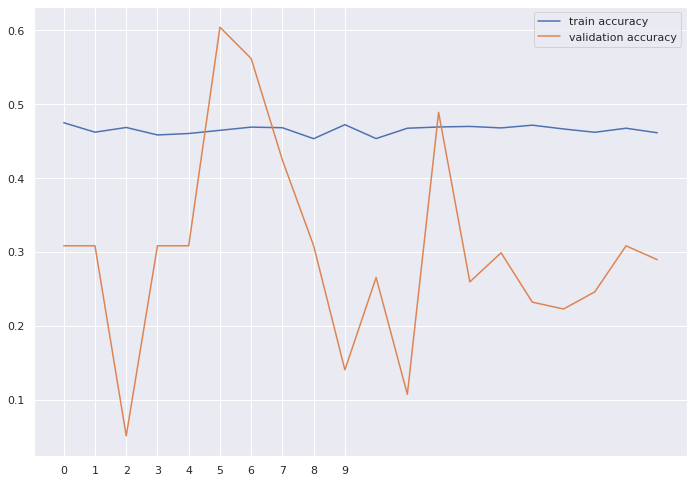

In [ ]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['accuracy'], label='train accuracy')

plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks(np.arange(10))
plt.legend()


In [ ]:
model = network()

In [ ]:
!pip install visualkeras ; ! pip install ThreadedFileLoader # module for CNN visualization


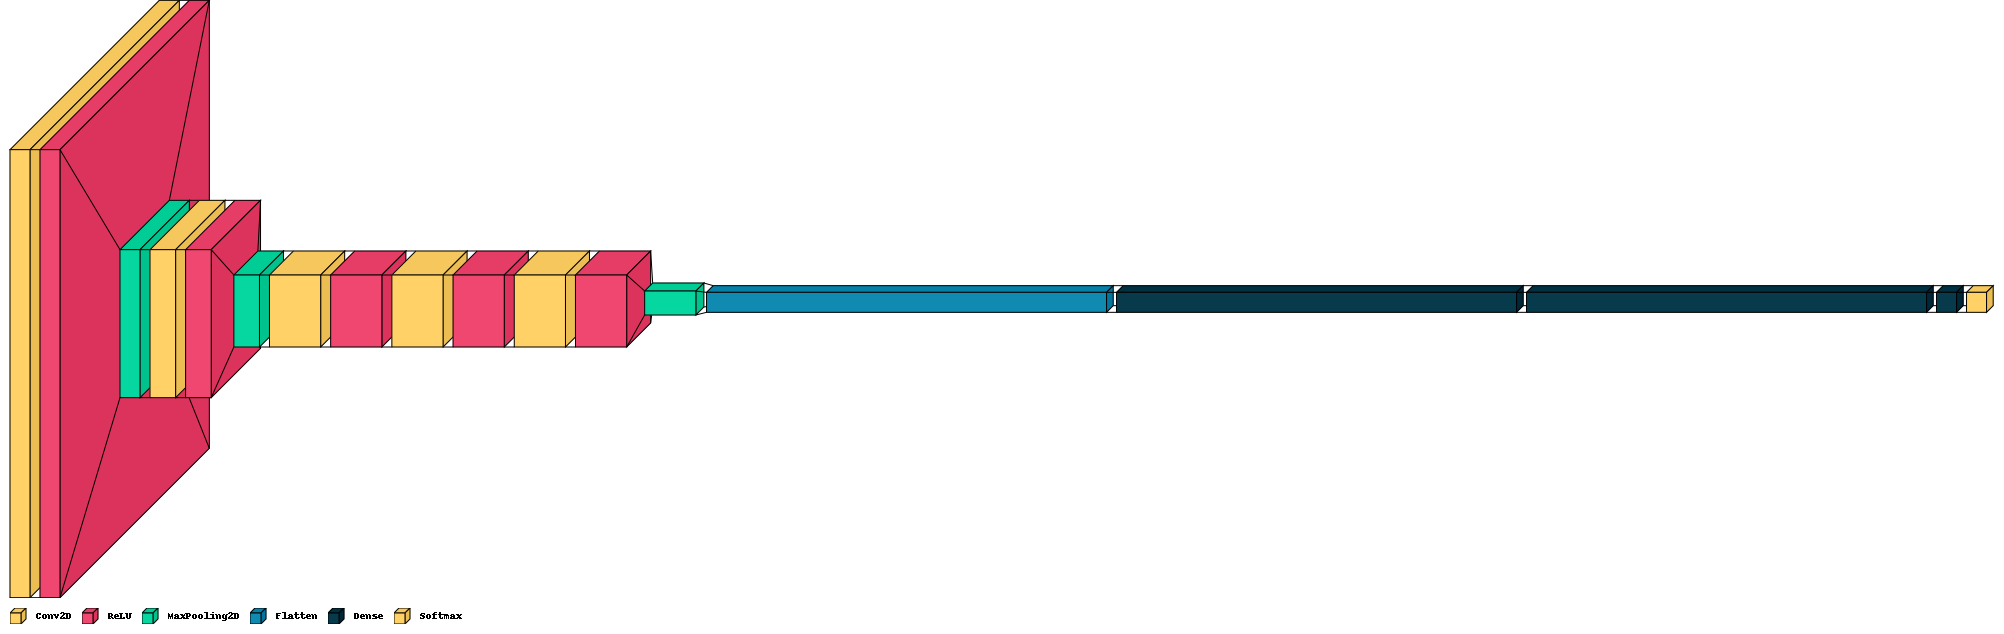

In [ ]:
visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Track progress
    train_loss_avg.update_state(loss_value)
    train_accuracy.update_state(y, logits)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y, set_name):
    logits = model(x)
    if set_name == 'val':
        val_accuracy.update_state(y, logits)
    else:
        test_accuracy.update_state(y, logits)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
create_log_dir(log_dir, checkpoint_dir)
train_summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
train_loss_avg = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.MeanAbsoluteError()
val_accuracy = tf.keras.metrics.MeanAbsoluteError()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
for epoch in range(EPOCHS):
    # Training loop
    for x_batch_train, y_batch_train in tqdm(train_set, total=1517):
        # Do step
        loss_value = train_step(x_batch_train, y_batch_train)
        
    # Test on validation set
    for x_batch_val, y_batch_val in val_set:
        test_step(x_batch_val, y_batch_val, 'val')
    
    # Reset training metrics at the end of each epoch
    train_acc = train_accuracy.result()
    train_accuracy.reset_states()
    val_acc = val_accuracy.result()
    val_accuracy.reset_states()
    
    with train_summary_writer.as_default():
        tf.summary.scalar('Train loss', train_loss_avg.result(), step=epoch)
        tf.summary.scalar('Train MAE', train_acc, step=epoch)
        tf.summary.scalar('Val MAE', val_acc, step=epoch)
        
    if epoch % 10 == 0:
        tf.keras.models.save_model(model, '{}/Epoch_{}_model.hp5'.format(checkpoint_dir, str(epoch)), save_format="h5")

 55%|█████▍    | 833/1517 [00:39<00:32, 20.84it/s]


 55%|█████▍    | 833/1517 [00:39<00:32, 20.88it/s]


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir /content/logs

### Saving Models

In [ ]:
!zip -r scratch_models.zip /content/checkpoints/scratch_aug

  adding: content/checkpoints/scratch_aug/ (stored 0%)
  adding: content/checkpoints/scratch_aug/Epoch_250_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_0_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_350_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_450_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_100_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_200_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_50_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_400_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_150_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_300_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_500_model.hp5 (deflated 7%)


In [ ]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("/content/tfrecords/train.tfrecords")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

In [ ]:
example
